In [1]:
import argparse
import logging
import ipdb
import os
import sys
import torch
import random
import importlib
import yaml
from box import Box
from pathlib import Path

import src

In [2]:
import os
import random
import numpy as np
import cv2
import scipy.ndimage.morphology as ndi_morph
from skimage.morphology import remove_small_objects

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
from scipy.ndimage import distance_transform_edt

In [5]:
def _get_instance(module, config, *args):
    """
    Args:
        module (module): The python module.
        config (Box): The config to create the class object.

    Returns:
        instance (object): The class object defined in the module.
    """
    cls = getattr(module, config.name)
    kwargs = config.get('kwargs')
    return cls(*args, **config.kwargs) if kwargs else cls(*args)

In [6]:
config_path = Path('/home/vincentwu-cmlab/template/configs/train/train_initial_seg_3cls_label_config.yaml')
config = Box.from_yaml(filename=config_path)

In [7]:
config

<Box: {'main': {'random_seed': 0, 'saved_dir': '/home/vincentwu-cmlab/template/models/nuclei_initial_seg_3cls_label_dice_resnet50_all'}, 'dataset': {'name': 'NucleiInitialSegDataset', 'kwargs': {'data_dir': '/home/vincentwu-cmlab/cell_data/DSB2018plus/nucleisegmentationbenchmark', 'data_split_list': '/home/vincentwu-cmlab/template/data_split/DSB2018plus/nucleisegmentationbenchmark/train_val_test.json', 'label_type': '3cls_label', 'label_proportion': 0.5, 'train_transforms': [{'name': 'RandomResize', 'kwargs': {'scale': [0.5, 1.5], 'ratio': [1.0, 1.0], 'prob': 0.25}}, {'name': 'RandomRotation', 'kwargs': {'degrees': [-30.0, 30.0], 'prob': 0.25}}, {'name': 'RandomHorizontalFlip', 'kwargs': {'prob': 0.25}}, {'name': 'RandomVerticalFlip', 'kwargs': {'prob': 0.25}}, {'name': 'RandomCrop', 'kwargs': {'size': [256, 256]}}, {'name': 'Normalize', 'kwargs': {'means': [0.485, 0.456, 0.406], 'stds': [0.229, 0.224, 0.225]}}, {'name': 'ToTensor'}], 'valid_transforms': [{'name': 'Normalize', 'kwargs'

In [8]:
device = torch.device(config.trainer.kwargs.device)

In [9]:
config.dataset.kwargs.update(config.main.random_seed)
data_dir = Path(config.dataset.kwargs.data_dir)
config.dataset.kwargs.update(data_dir=data_dir, type='train')
train_dataset = _get_instance(src.data.datasets, config.dataset)
config.dataset.kwargs.update(data_dir=data_dir, type='val')
valid_dataset = _get_instance(src.data.datasets, config.dataset)

In [10]:
config.dataloader.kwargs

<Box: {'train_batch_size': 16, 'valid_batch_size': 1, 'shuffle': True, 'num_workers': 8}>

In [11]:
cls = getattr(src.data.datasets, config.dataset.name)
train_batch_size, valid_batch_size = config.dataloader.kwargs.pop('train_batch_size'), config.dataloader.kwargs.pop('valid_batch_size')
config.dataloader.kwargs.update(collate_fn=getattr(cls, 'collate_fn', None), batch_size=train_batch_size)
train_dataloader = _get_instance(src.data.dataloader, config.dataloader, train_dataset)
config.dataloader.kwargs.update(batch_size=valid_batch_size)
valid_dataloader = _get_instance(src.data.dataloader, config.dataloader, valid_dataset)

In [12]:
net = _get_instance(src.model.nets, config.net)

In [13]:
checkpoint = torch.load(Path('/home/vincentwu-cmlab/template/models/nuclei_initial_seg_3cls_label_dice_resnet50_all/checkpoints/model_best.pth'), map_location=device)
net.load_state_dict(checkpoint['net'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
for valid_batch in valid_dataloader:
    ori_image_  = valid_batch['ori_image']
    image_  = valid_batch['image']
    semi_label_  = valid_batch['semi_label']
    full_label_  = valid_batch['full_label']
    break

In [15]:
with torch.no_grad():
    outputs_ = net(image_)

In [16]:
ori_image = ori_image_.detach().cpu().numpy().transpose(0,2,3,1).squeeze().astype(np.uint8)

In [17]:
outputs = outputs_.detach().cpu().numpy().transpose(0,2,3,1).squeeze()

In [18]:
semi_label = semi_label_.detach().cpu().numpy().transpose(0,2,3,1).squeeze()

In [19]:
full_label = full_label_.detach().cpu().numpy().transpose(0,2,3,1).squeeze()

In [20]:
outputs.shape

(512, 488, 3)

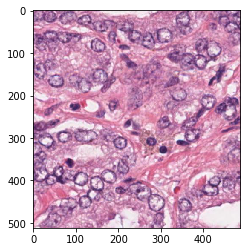

In [21]:
plt.imshow(ori_image)
plt.show()

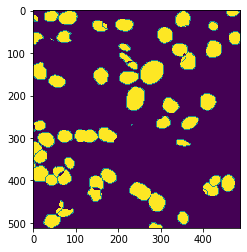

In [22]:
plt.imshow(semi_label)
plt.show()

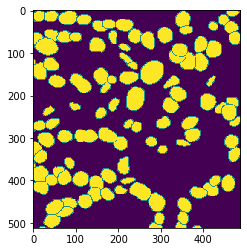

In [23]:
plt.imshow(full_label)
plt.show()

In [24]:
outputs = np.argmax(outputs, axis=-1)

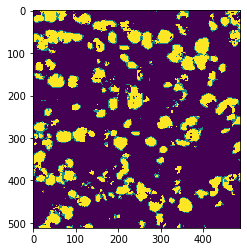

In [25]:
plt.imshow(outputs)
plt.show()

In [26]:
outputs_masks_inner = outputs.copy()
outputs_masks_inner[np.isin(outputs_masks_inner, 1)]=0

In [27]:
outputs_local_maxi = peak_local_max(
   outputs_masks_inner, indices=False, min_distance=3, exclude_border=False)
outputs_markers = measure.label(outputs_local_maxi, connectivity=2, background=0)

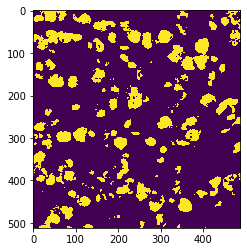

In [28]:
plt.imshow(outputs_local_maxi)
plt.show()

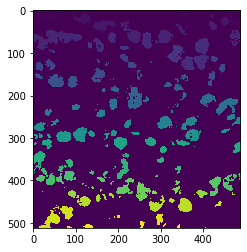

In [29]:
plt.imshow(outputs_markers)
plt.show()

In [30]:
outputs_labels_ws = watershed(-outputs, outputs_markers, mask=outputs>0)

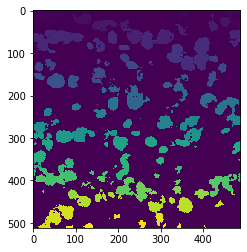

In [31]:
plt.imshow(outputs_labels_ws)
plt.show()

In [32]:
np.unique(outputs_labels_ws)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [33]:
outputs_markers[np.where(outputs==0)] = -1
outputs_labels_rw = random_walker(outputs>0, outputs_markers, beta=10)
outputs_labels_rw[np.where(outputs_labels_rw==-1)]=0
outputs_labels_rw = measure.label(outputs_labels_rw, connectivity=1, background=0)

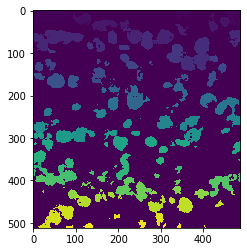

In [34]:
plt.imshow(outputs_labels_rw)
plt.show()

In [35]:
np.unique(outputs_labels_rw)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [36]:
semi_label_masks_inner = semi_label.copy()
semi_label_masks_inner[np.isin(semi_label_masks_inner, 1)]=0
semi_label_local_maxi = peak_local_max(
   semi_label_masks_inner, indices=False, min_distance=3, exclude_border=False)
semi_label_markers = measure.label(semi_label_local_maxi, connectivity=2, background=0)
semi_label_labels_ws = watershed(-semi_label, semi_label_markers, mask=semi_label>0)
semi_label_markers[np.where(semi_label==0)] = -1
semi_label_labels_rw = random_walker(semi_label>0, semi_label_markers, beta=10)
semi_label_labels_rw[np.where(semi_label_labels_rw==-1)]=0
semi_label_labels_rw = measure.label(semi_label_labels_rw, connectivity=1, background=0)

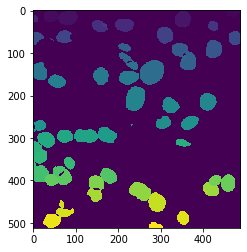

In [37]:
plt.imshow(semi_label_labels_ws)
plt.show()

In [38]:
np.unique(semi_label_labels_ws)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int32)

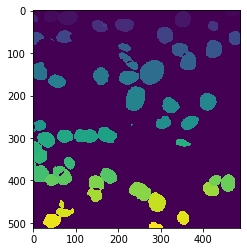

In [39]:
plt.imshow(semi_label_labels_rw)
plt.show()

In [40]:
np.unique(semi_label_labels_rw)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [41]:
full_label_masks_inner = full_label.copy()
full_label_masks_inner[np.isin(full_label_masks_inner, 1)]=0
full_label_local_maxi = peak_local_max(
   full_label_masks_inner, indices=False, min_distance=3, exclude_border=False)
full_label_markers = measure.label(full_label_local_maxi, connectivity=2, background=0)
full_label_labels_ws = watershed(-full_label, full_label_markers, mask=full_label>0)
full_label_markers[np.where(full_label==0)] = -1
full_label_labels_rw = random_walker(full_label>0, full_label_markers, beta=10)
full_label_labels_rw[np.where(full_label_labels_rw==-1)]=0
full_label_labels_rw = measure.label(full_label_labels_rw, connectivity=1, background=0)

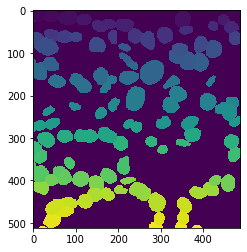

In [42]:
plt.imshow(full_label_labels_ws)
plt.show()

In [43]:
np.unique(full_label_labels_ws)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113], dtype=int32)

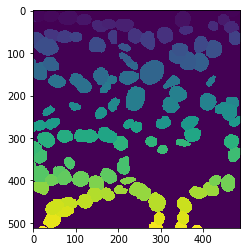

In [44]:
plt.imshow(full_label_labels_rw)
plt.show()

In [45]:
np.unique(full_label_labels_rw)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113])